# Data collection

In [1]:
with open('/home/fullerite/Documents/Jupyter/nn_zero_to_hero/lecture2/names_dataset.txt', 'r') as f:
    words = f.read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [2]:
min(words, key=len)

'an'

In [3]:
max(words, key=len)

'muhammadibrahim'

In [4]:
counter = {}

for word in words:
    chrs = ['<S>'] + list(word) + ['<E>']
    for ch1, ch2 in zip(chrs, chrs[1:]):
        bigram = (ch1, ch2)
        counter[bigram] = counter.get(bigram, 0) + 1

In [5]:
sorted(counter.items(), key=lambda kv: kv[1], reverse=True)

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [6]:
import torch

In [7]:
chars = sorted(list(set(''.join(words))))
string_to_index = {s:i for i, s in enumerate(chars)}
string_to_index['<S>'] = 26
string_to_index['<E>'] = 27

In [8]:
N = torch.zeros((28, 28), dtype=torch.int32)

for word in words:
    chrs = ['<S>'] + list(word) + ['<E>']
    for ch1, ch2 in zip(chrs, chrs[1:]):
        ch1_i = string_to_index[ch1]
        ch2_i = string_to_index[ch2]
        N[ch1_i, ch2_i] += 1

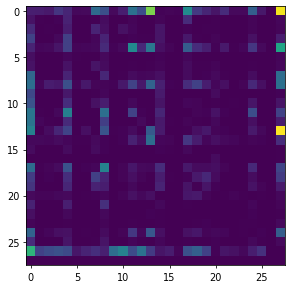

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 70

plt.imshow(N)

(-0.5, 27.5, 27.5, -0.5)

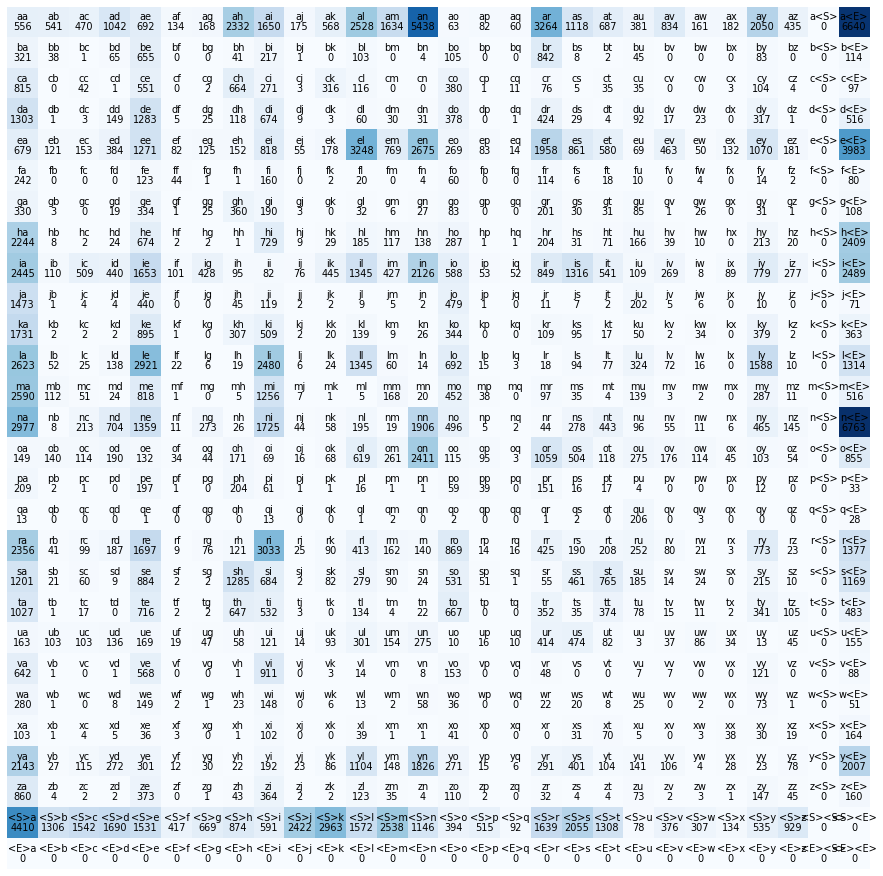

In [10]:
index_to_string = {i:s for s, i in string_to_index.items()}

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(28):
    for j in range(28):
        charstring = index_to_string[i] + index_to_string[j]
        plt.text(j, i, charstring, ha='center', va='bottom', color='black')
        plt.text(j, i, N[i,j].item(), ha='center', va='top', color='black')
plt.axis('off')

# Probability based bigram name generator

## Reading counts from the data set

In [11]:
chars = sorted(list(set(''.join(words))))
string_to_index = {s:i+1 for i, s in enumerate(chars)} # offset the normal characters 
                                            # so that special character will be placed at 0
string_to_index['.'] = 0 # single special character for convenience 
index_to_string = {i:s for s, i in string_to_index.items()}

In [12]:
N = torch.zeros((27, 27), dtype=torch.int32)

for word in words:
    chrs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chrs, chrs[1:]):
        ch1_i = string_to_index[ch1]
        ch2_i = string_to_index[ch2]
        N[ch1_i, ch2_i] += 1

(-0.5, 26.5, 26.5, -0.5)

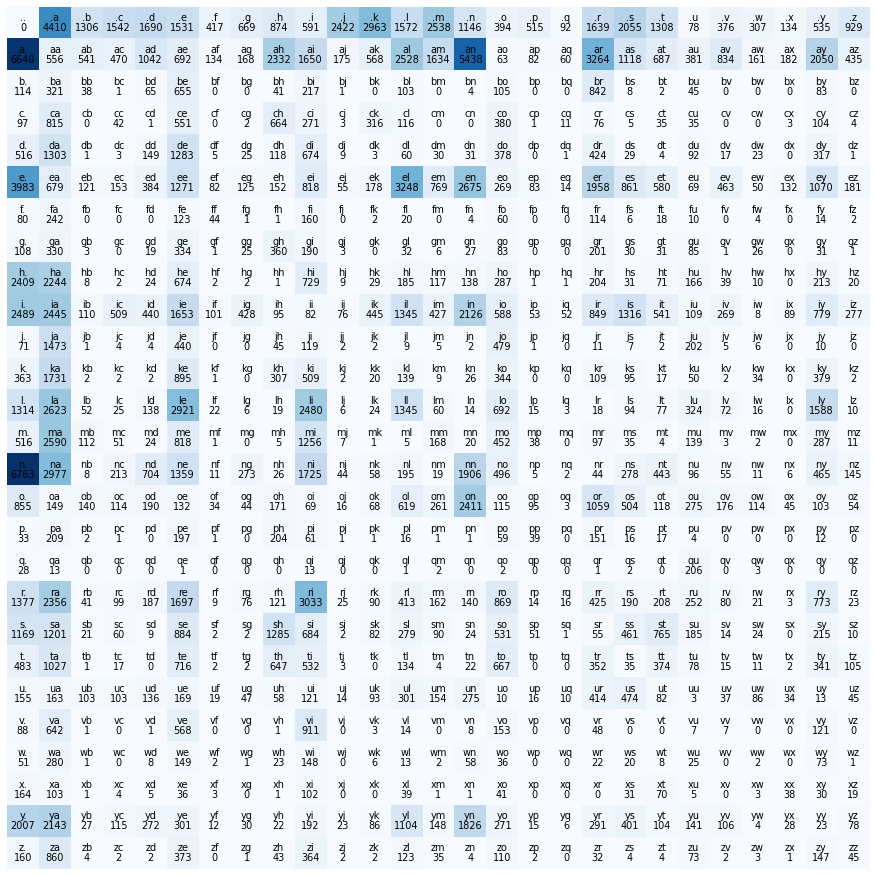

In [13]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        charstring = index_to_string[i] + index_to_string[j]
        plt.text(j, i, charstring, ha='center', va='bottom', color='black')
        plt.text(j, i, N[i,j].item(), ha='center', va='top', color='black')
plt.axis('off')

## Probabilities calculation

In [14]:
P = (N+1).float() # model smoothing, so that there will be no 0 probabilities (log(0) = -inf)
sum_vector = P.sum(1, keepdim=True) # sums the tensor entries along the dimension 1(columns) and collapses it
                        # and keeps the dimension, so that it outputs a 27x1 vector and not a 27 element 1D array

# P.shape = [27,27]
# sum_vector.shape = [27,1]
# according to broadcasting rules, we can divide [27,27] by [27,1]
# 1) sum_vector is aligned to [27,27] (the column is copied and pasted 27 times)
# 2) P is divided (element-wise) by the aligned sum_vector
P /= sum_vector # normalize the probability distribution

## Sampling

In [15]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
    name = ''
    index = 0 # base case, starting special token '.'
    while True:
        probability = P[index] # optimization by direct access of precomputed values
        index = torch.multinomial(probability, num_samples=1, generator=g).item() # sample the next index
                                                                                # based on probability table
        if index != 0:
            name += index_to_string[index] # append the character that was sampled from the probability distribution
        if index == 0: # the end special token
            break

    print(name)

junide
janasah
p
cony
a
nn
kohin
tolian
juee
ksahnaauranilevias


# Nueral network for bigram name generator

## Loss function

In [16]:
log_likelihood = 0.0

for w in words[:3]:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ch1_i = string_to_index[ch1]
        ch2_i = string_to_index[ch2]
        prob = P[ch1_i, ch2_i] # probability of ch2 following ch1
        log_prob = torch.log(prob) # log of the probability
        log_likelihood += log_prob # log likelihood = log(a*b*c*...) = log(a) + log(b) + log(c) + ...
        print(f"{ch1}{ch2}: {prob:.4f} {log_prob:.4f}")

print(f"{log_likelihood=}")

.e: 0.0478 -3.0410
em: 0.0377 -3.2793
mm: 0.0253 -3.6753
ma: 0.3885 -0.9454
a.: 0.1958 -1.6305
.o: 0.0123 -4.3965
ol: 0.0779 -2.5526
li: 0.1774 -1.7293
iv: 0.0152 -4.1845
vi: 0.3508 -1.0476
ia: 0.1380 -1.9807
a.: 0.1958 -1.6305
.a: 0.1376 -1.9835
av: 0.0246 -3.7041
va: 0.2473 -1.3971
a.: 0.1958 -1.6305
log_likelihood=tensor(-38.8086)


In [17]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

log_likelihood = 0.0
counter = 0
average_negative_log_likelihood = 0.0

for w in words:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ch1_i = string_to_index[ch1]
        ch2_i = string_to_index[ch2]
        prob = P[ch1_i, ch2_i]
        log_prob = torch.log(prob)
        log_likelihood += log_prob
        counter += 1

average_negative_log_likelihood = -log_likelihood / counter # loss function 
print(f"{average_negative_log_likelihood}")

2.4543561935424805


## Training samples encoding

In [18]:
# training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ch1_i = string_to_index[ch1] # the first character index
        ch2_i = string_to_index[ch2] # index of the character that is expected to be next
        xs.append(ch1_i)
        ys.append(ch2_i)

xs = torch.tensor(xs) # first characters
ys = torch.tensor(ys) # the characters that are expected to go next,
                      # i.e x[i] is expected to be followed by y[i]
print(xs, ys, sep='\n')

tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([5, 27])
torch.Size([27])


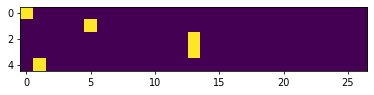

In [19]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float() # one-hot encoding for indexes of the first characters
                                            # casting to float is important to feed these into a neural net
                                            # num_classes=27 since there are 27 possible characters
print(xenc, xenc.shape, sep='\n')
print(xenc[0].shape)
plt.imshow(xenc)

In [20]:
# xenc, which encodes the first name '.emma.',
# essentially contains 5 bigrams, i.e 5 training samples
W = torch.randn((27, 1)) # randomly generated weights for the first neuron of the first hidden layer

# xenc consists of 5 27-dimensional row-vectors (1D tensors)
# we want to calculate the dot-product of each vector(input)
# with the first hidden layer weights (z = w1,1*x1 + w1,2*x2 +... + w1,27*x27)
# this can be efficiently done using matrix multiplication (operator@ == torch.matmul)
# [5, 27] @ [27, 1] = [5, 1]
# in the end we get the weighted sums for the first neuron of the first hidden layer for all 5 training samples
print(xenc.shape, W.shape)
xenc @ W

torch.Size([5, 27]) torch.Size([27, 1])


tensor([[ 0.5325],
        [-0.0402],
        [-0.7589],
        [-0.7589],
        [ 0.1413]])

In [21]:
# now if we have 27 neurons in the first hidden layer, we can do the same operation
W = torch.randn((27, 27)) # 27 neurons with 27 weights (since one-hot encoding is 27 dimensional)
                                       # first column contains the weights connecting the first hidden layer neurons
                                       # to all 27 input neurons, etc.
xenc @ W # evaluates all the 27 neurons on all the 5 training samples
# [x1 ... x27]
# [.   .   .]
# [z1 ... z27]
#
# [w1,1  ...  w27,1]
# [ .     .     .  ]
# [ .     .     .  ]
# [w1,27 ... w27,27]
# for example, (xenc@W)[3, 13] is the activation of the 14th neuron when looking at input sample 4
# this is equivalent to the dot-product (xenc[3] * W[:, 13]).sum()

tensor([[ 0.1161,  2.7129, -0.2740, -1.1158, -0.2883, -0.4259,  0.8641, -0.0735,
          1.4195, -0.1920, -2.1519,  0.5656, -0.0681,  0.6939, -1.0404,  0.6272,
          0.8220,  1.1215, -1.2096, -1.5670,  0.4954, -0.3767,  0.2388,  0.0956,
         -2.0764, -0.3511, -1.4765],
        [-0.1852, -0.9035,  0.3669,  1.7370, -0.5223,  0.1125,  0.0588, -1.9416,
          1.9916,  3.1199, -0.1548, -1.0458,  1.8459, -1.8530, -1.0954, -0.1239,
         -0.9107,  0.7998,  0.4924,  1.4279,  1.4696,  0.1475, -1.9538,  0.5616,
          0.6258, -0.8324,  0.5093],
        [ 0.3665, -0.2352,  0.3889,  0.2007,  1.2998,  0.4673,  0.5596, -2.5609,
          0.4629,  1.1266,  1.0578,  2.1131, -0.8840, -0.3794,  0.4480, -1.8956,
         -1.2904,  0.0315,  1.0535, -0.2454, -1.0277, -0.5092,  2.0971,  0.0303,
          1.4683,  0.4881,  0.8082],
        [ 0.3665, -0.2352,  0.3889,  0.2007,  1.2998,  0.4673,  0.5596, -2.5609,
          0.4629,  1.1266,  1.0578,  2.1131, -0.8840, -0.3794,  0.4480, -1.8956

## Neurnal net output interpretation

In [22]:
logits = xenc @ W # log-counts or logits
counts = logits.exp() # sort of similar to matrix N from above
probs = counts / counts.sum(dim=1, keepdim=True) # normalize the rows to get probabilities

In [23]:
# so now we have 5 outputs(for 5 input samples) of our 1-layered nerual net
# each of which can be interpreted as a probability distribution
print(probs[0].sum())
probs[0] # for example, this is interpreted output of (xenc@W)[0],
         # which is essentially the output of the nerual net
         # when we fed it the first token of '.emma.', i.e '.'
         # its shape is [27],
         # so it represents how likely any of the 27 characters
         # is to follow the '.'

tensor(1.0000)


tensor([0.0246, 0.3306, 0.0167, 0.0072, 0.0164, 0.0143, 0.0520, 0.0204, 0.0907,
        0.0181, 0.0026, 0.0386, 0.0205, 0.0439, 0.0077, 0.0411, 0.0499, 0.0673,
        0.0065, 0.0046, 0.0360, 0.0150, 0.0278, 0.0241, 0.0027, 0.0154, 0.0050])

## Summary

In [24]:
xs # inputs to the neural net

tensor([ 0,  5, 13, 13,  1])

In [25]:
ys # label, correct next characters in a sequence

tensor([ 5, 13, 13,  1,  0])

In [26]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g) # randomly generated weights 
                                       # for the first neuron of the hidden layer

In [27]:
# FORWARD PASS
xenc = F.one_hot(xs, num_classes=27).float() # input to the neural net in one-hot encoding
logits = xenc @ W # feed in one-hot enocded xs, get predicted log-"counts"
counts = logits.exp() # "counts", equivalent to previously mentioned N
probs = counts / counts.sum(dim=1, keepdim=True) # probabilities for the next character
# the two lasts lines are softmax activation function

In [28]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {index_to_string[x]}{index_to_string[y]} (indexes {x}, {y})')
  print(f'input to the neural net: {x} (index)')
  print('output probabilities from the neural net:', probs[i])
  print(f'label (actual next character): {y} (index)')
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0, 5)
input to the neural net: 0 (index)
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5 (index)
probability assigned by the net to the the correct character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
--------
bigram example 2: em (indexes 5, 13)
input to the neural net: 5 (index)
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13 (index)
probability assigned by the ne

## Neural net optimization (preparation)

In [29]:
xs

tensor([ 0,  5, 13, 13,  1])

In [30]:
ys

tensor([ 5, 13, 13,  1,  0])

In [31]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True) # requires_grad is very important

In [32]:
# FORWARD PASS
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
loss = - probs[torch.arange(5), ys].log().mean() # negative average log-likelihood
# our loss function is negative log likelihood, because our task is classification
# instead of MSE for a regression task (e.g example from micrograd)

In [33]:
print(loss.item())

3.7693049907684326


In [34]:
# BACKWARD PASS
W.grad = None # set gradients to zero
loss.backward()

In [35]:
W.data += -0.1 * W.grad # update the weights

## Neural net optimization

In [36]:
# create the dataset
xs, ys = [], []

for w in words:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ch1_i = string_to_index[ch1]
        ch2_i = string_to_index[ch2]
        xs.append(ch1_i)
        ys.append(ch2_i)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('Number of training samples:', num)

# initialize the neural net (consists of 1 linear hidden layer with softmax)
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

Number of training samples: 228146


In [37]:
# 10 iterations of gradient descent
for k in range(200):

    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = - probs[torch.arange(num), ys].log().mean()

    # backwards pass
    W.grad = None
    loss.backward()
    
    # update the weights
    W.data += -50 * W.grad

    if k == 199:
        print(loss.item())

2.462393045425415


## Sampling from the trained neural net

In [38]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
    name = ''
    index = 0 # base case, starting special token '.'

    while True:
        xenc = F.one_hot(torch.tensor([index]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        probability = counts / counts.sum(dim=1, keepdim=True)

        index = torch.multinomial(probability, num_samples=1, generator=g).item() # sample the next index
                                                                                # based on the neural net output
        if index != 0:
            name += index_to_string[index] # append the character that was sampled from the probability distribution
        if index == 0: # the end special token
            break

    print(name)

junide
janasah
prelay
a
nn
kohin
tolian
juee
ksahnaauranilevias
dedainrwieta
